## Packages

In [42]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split as tts, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, recall_score, f1_score, precision_score, roc_auc_score, roc_curve

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


import seaborn as sns
import matplotlib.pyplot as plt

## Open Data

In [ ]:
data = pd.read_csv("./data/working data/Filing_Dataset_Imputated.csv")

X = data.drop(["filings","filing_rate"], axis=1)
y_filing = data["filings"]
y_rate = data["filings"]

## Functions

In [44]:
####################################################################################################

def evaluate_classifier(model, X_train, y_train, X_test, y_test):
    
    y_pred = model.predict(X_test)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Compute Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Precision, Recall, and F1-Score
    precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
    
    # Initialize ROC variables
    roc_auc = 'N/A'
    fpr, tpr = None, None

    # Try computing ROC AUC before plotting
    if len(np.unique(y_test)) == 2 and hasattr(model, 'predict_proba'):
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_proba)
            fpr, tpr, _ = roc_curve(y_test, y_proba)
        except Exception as e:
            roc_auc = f'Error: {e}'

    # Output all metrics
    metrics = {
        'Accuracy': accuracy,
        'MSE': mse,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Confusion Matrix': cm
    }

    print("\n--- Evaluation Metrics ---")
    for key, value in metrics.items():
        if isinstance(value, float):
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")
    
    # Prepare the side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot ROC Curve if applicable
    if isinstance(fpr, np.ndarray) and isinstance(tpr, np.ndarray):
        axes[0].plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
        axes[0].plot([0, 1], [0, 1], color='red', linestyle='--')
        axes[0].set_xlim([0.0, 1.0])
        axes[0].set_ylim([0.0, 1.05])
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title('Receiver Operating Characteristic')
        axes[0].legend(loc='lower right')
    else:
        axes[0].axis('off')
        msg = 'ROC Curve\nNot Available\n'
        if len(np.unique(y_test)) != 2:
            msg += '(Multi-Class)'
        else:
            msg += '(No predict_proba)'
        axes[0].text(0.5, 0.5, msg, ha='center', va='center', fontsize=12)

    # Plot Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_ if hasattr(model, "classes_") else None,
                yticklabels=model.classes_ if hasattr(model, "classes_") else None,
                ax=axes[1])
    axes[1].set_title('Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    
    plt.tight_layout()
    plt.show()
    
    return metrics

####################################################################################################

def compare_model_metrics(metrics_list, model_names=None):
    
    if model_names is None:
        model_names = [f'Model {i+1}' for i in range(len(metrics_list))]
    
    if len(model_names) != len(metrics_list):
        raise ValueError("Length of model_names must match length of metrics_list")

    rows = []
    for name, metrics in zip(model_names, metrics_list):
        row = {'Model': name}
        for k, v in metrics.items():
            if k == 'Confusion Matrix':
                continue  # Skip matrix in table comparison
            row[k] = v if isinstance(v, (int, float)) else str(v)
        rows.append(row)

    df = pd.DataFrame(rows)
    df.set_index('Model', inplace=True)
    return df

####################################################################################################

## Filing Rate

### Discrete Classification

In [45]:
y_rate.describe()["50%"] # what is the 50th percentile cutoff?

np.float64(10.0)

In [46]:
y_rate_discrete = (y_rate >= y_rate.describe()["50%"]).astype(int) # anything above the 50th = 1/high rates, below = 0/low rates


In [47]:
y_discrete = (y_filing >= y_filing.describe()["50%"]).astype(int) # anything above the 50th = 1/high rates, below = 0/low rates


In [48]:
y_discrete.value_counts()

filings
1    755
0    743
Name: count, dtype: int64

In [49]:
y_rate_discrete.value_counts()

filings
1    755
0    743
Name: count, dtype: int64

In [50]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X) # normalize X

In [51]:
X_train, X_test, y_train, y_test = tts(X_scaled, y_rate_discrete, test_size=0.2, random_state=42)

#### Logistic Regression

In [ ]:
param_grid = {
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'C': [.01, .1, 1, 10, 100],
    'l1_ratio': [.01,.5, .9],
}

model = LogisticRegression(max_iter=2000)

grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5)

grid_search.fit(X_train, y_train)


--- Evaluation Metrics ---
Accuracy: 0.8300
MSE: 0.1700
Precision: 0.8101
Recall: 0.8591
F1 Score: 0.8339
ROC AUC: 0.9106
Confusion Matrix: [[121  30]
 [ 21 128]]


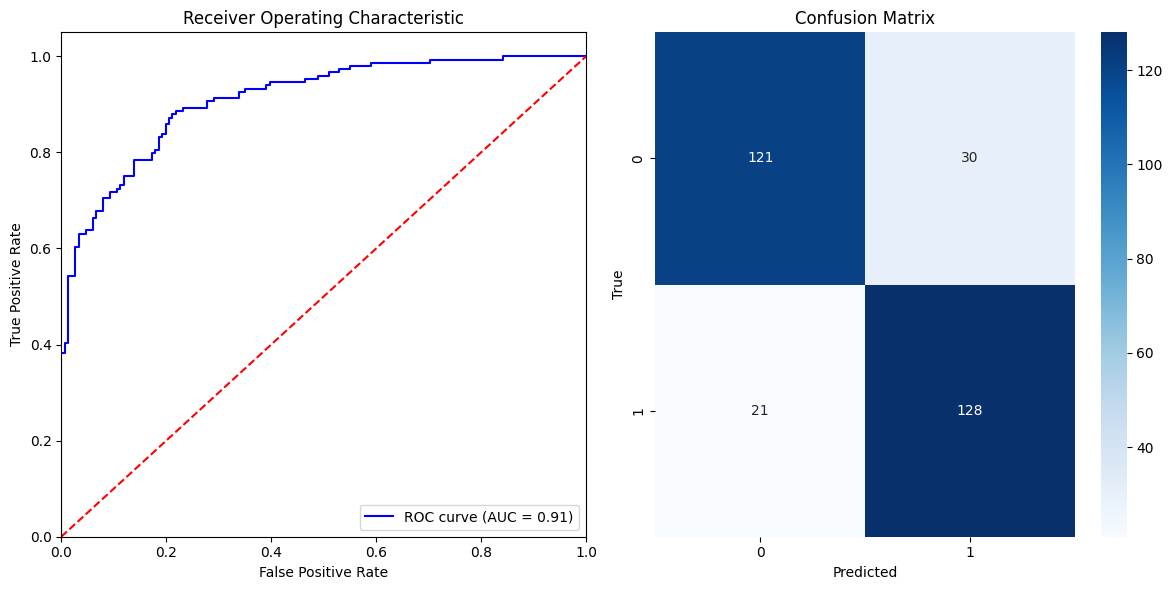

{'Accuracy': 0.83,
 'MSE': np.float64(0.17),
 'Precision': np.float64(0.810126582278481),
 'Recall': np.float64(0.8590604026845637),
 'F1 Score': np.float64(0.8338762214983714),
 'ROC AUC': np.float64(0.9105738032801459),
 'Confusion Matrix': array([[121,  30],
        [ 21, 128]])}

In [ ]:
evaluate_classifier(grid_search, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [ ]:
logistic_regression_metrics = {'Accuracy': 0.83,
 'MSE': np.float64(0.17),
 'Precision': np.float64(0.810126582278481),
 'Recall': np.float64(0.8590604026845637),
 'F1 Score': np.float64(0.8338762214983714),
 'ROC AUC': np.float64(0.9105738032801459),
 'Confusion Matrix': np.array([[121,  30],
        [ 21, 128]])}

#### Random Forest Classifier

In [ ]:
rfc_param_grid = {
    'n_estimators': [50, 100, 200, 500],              # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],                   # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],                   # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                     # Minimum samples required at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],          # Number of features to consider at each split
}

rfc_model = RandomForestClassifier()

rfc_grid_search = GridSearchCV(estimator=rfc_model,
                           param_grid=rfc_param_grid,
                           cv=5)

rfc_grid_search.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 500]})


--- Evaluation Metrics ---
Accuracy: 0.8233
MSE: 0.1767
Precision: 0.7857
Recall: 0.8859
F1 Score: 0.8328
ROC AUC: 0.9156
Confusion Matrix: [[115  36]
 [ 17 132]]


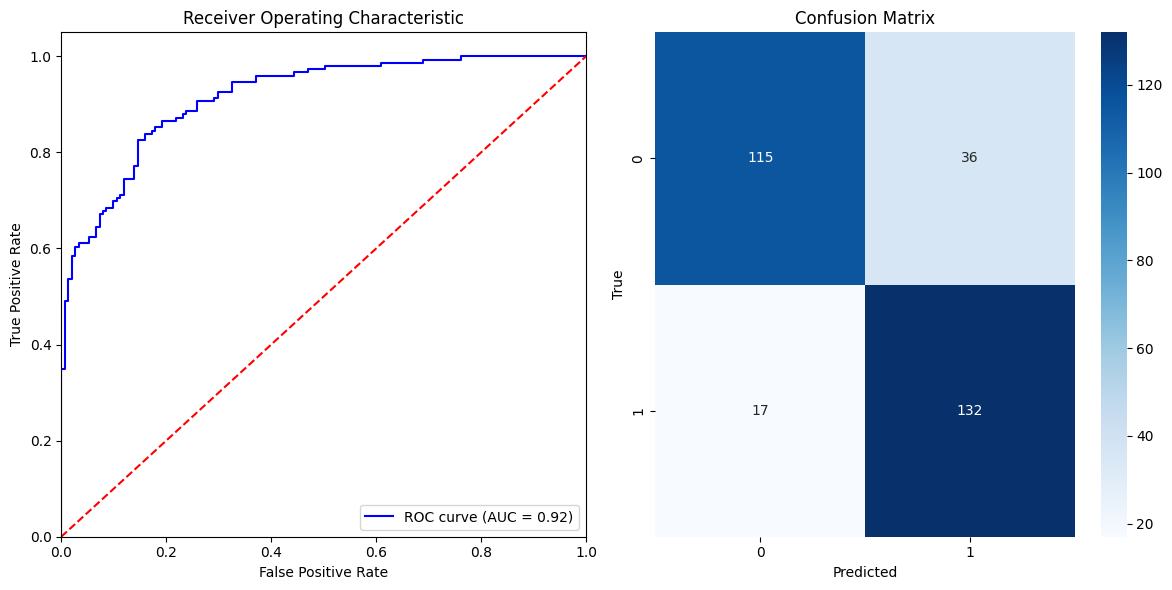

{'Accuracy': 0.8233333333333334,
 'MSE': np.float64(0.17666666666666667),
 'Precision': np.float64(0.7857142857142857),
 'Recall': np.float64(0.8859060402684564),
 'F1 Score': np.float64(0.832807570977918),
 'ROC AUC': np.float64(0.9155962487221655),
 'Confusion Matrix': array([[115,  36],
        [ 17, 132]])}

In [ ]:
evaluate_classifier(rfc_grid_search, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [ ]:
rfc_metrics = {'Accuracy': 0.8233333333333334,
 'MSE': np.float64(0.17666666666666667),
 'Precision': np.float64(0.7857142857142857),
 'Recall': np.float64(0.8859060402684564),
 'F1 Score': np.float64(0.832807570977918),
 'ROC AUC': np.float64(0.9155962487221655),
 'Confusion Matrix': np.array([[115,  36],
        [ 17, 132]])}

#### Support Vector Classifier

In [ ]:
svc_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],              # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel types
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1], # Kernel coefficient for 'rbf', 'poly', 'sigmoid'
    'degree': [2, 3, 4]                  # Degree for 'poly' kernel
}

svc_model = SVC()

svc_grid_search = GridSearchCV(estimator=svc_model,
                           param_grid=svc_param_grid,
                           cv=5)

svc_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']})


--- Evaluation Metrics ---
Accuracy: 0.8100
MSE: 0.1900
Precision: 0.7771
Recall: 0.8658
F1 Score: 0.8190
ROC AUC: N/A
Confusion Matrix: [[114  37]
 [ 20 129]]


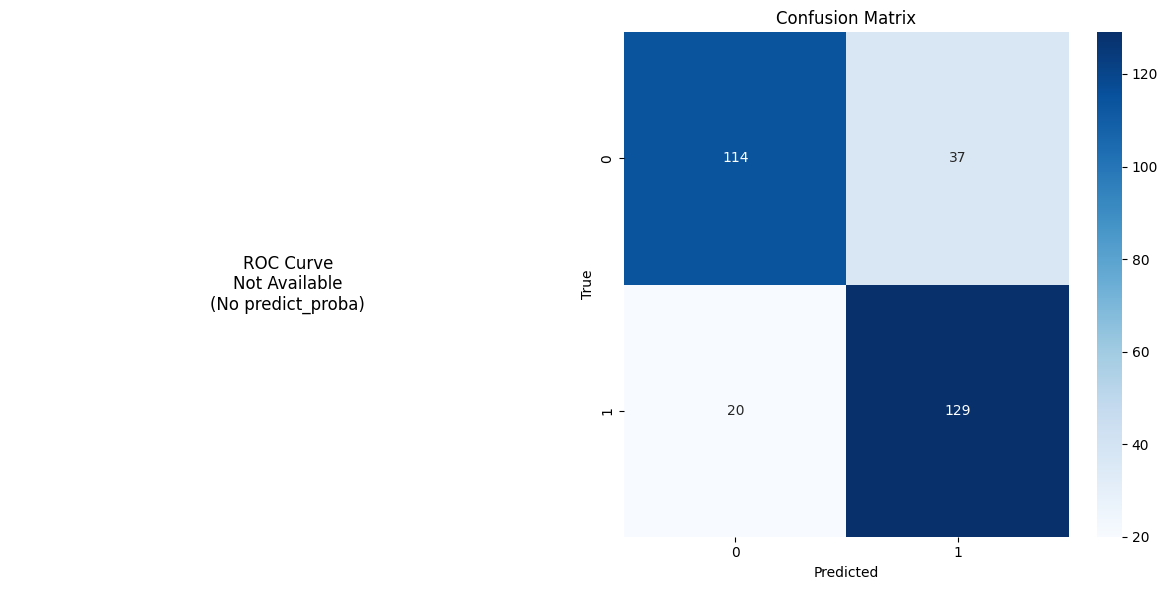

{'Accuracy': 0.81,
 'MSE': np.float64(0.19),
 'Precision': np.float64(0.7771084337349398),
 'Recall': np.float64(0.8657718120805369),
 'F1 Score': np.float64(0.819047619047619),
 'ROC AUC': 'N/A',
 'Confusion Matrix': array([[114,  37],
        [ 20, 129]])}

In [ ]:
evaluate_classifier(svc_grid_search, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [ ]:
svc_metrics = {'Accuracy': 0.81,
 'MSE': np.float64(0.19),
 'Precision': np.float64(0.7771084337349398),
 'Recall': np.float64(0.8657718120805369),
 'F1 Score': np.float64(0.819047619047619),
 'ROC AUC': 'N/A',
 'Confusion Matrix': np.array([[114,  37],
        [ 20, 129]])}

In [56]:
compare_model_metrics([logistic_regression_metrics,rfc_metrics,svc_metrics], ["Logistic Regression","Random Forest Classifier", "Support Vector Classifier"]).T.to_csv("./figs/classifiers.csv")

### Interpertation

In [68]:
def interpret_coefficients(model, feature_names):
    coefs = model.coef_[0]
    odds_ratios = np.exp(coefs)
    interpretation = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs,
        'Odds Ratio': odds_ratios
    })
    return interpretation.sort_values(by='Odds Ratio', ascending=False)

In [76]:
top_coefs = interpret_coefficients(grid_search.best_estimator_, list(X.columns))[:25]
top_coefs

,Feature,Coefficient,Odds Ratio
156,B25039_001E,0.292275,1.339472
43,B02001_003E,0.143204,1.153965
24,B25034_011E,0.134960,1.144491
50,B11001_006E,0.132703,1.141911
19,B25070_008E,0.131778,1.140854
65,B25074_010E,0.119082,1.126462
130,B25032_005E,0.109460,1.115675
27,B25092_001E,0.104516,1.110174
106,B16004_006E,0.101188,1.106484
21,B19057_002E,0.093731,1.098265


In [77]:
var_map = pd.read_csv('./data/acs/variables/acs5_2018_all_vars.csv')

In [80]:
top_coefs.merge(var_map, left_on="Feature", right_on="Variable").to_csv("./figs/lr_top_var.csv",index=False)